<a href="https://colab.research.google.com/github/buwituze/Fighting-model/blob/main/Fighting_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Fighting 3D CNN

In [1]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


Data loading and processing

In [2]:
# Dataset Loading & Processing

import os
import cv2
import numpy as np
from google.colab import drive
import random
from sklearn.utils import shuffle
from collections import Counter

drive.mount('/content/drive')

IMG_SIZE = 64 # 64x64 pixels
FRAMES_PER_VIDEO = 16 #
DATASET_PATH = '/content/drive/MyDrive/UBI_FIGHTS/videos'

def augment_frames(frames): # editing light, shape,
    augmented = frames.copy()

    if random.random() > 0.5:
        augmented = np.flip(augmented, axis=2)

    if random.random() > 0.5:
        brightness_factor = random.uniform(0.8, 1.2)
        augmented = np.clip(augmented * brightness_factor, 0, 255)

    if random.random() > 0.7:
        angle = random.uniform(-5, 5)
        for i in range(len(augmented)):
            center = (IMG_SIZE // 2, IMG_SIZE // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented[i] = cv2.warpAffine(augmented[i], rotation_matrix, (IMG_SIZE, IMG_SIZE))

    return augmented.astype(np.uint8)

def extract_frames(video_path, max_frames=FRAMES_PER_VIDEO):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < max_frames:
        step = 1
    else:
        step = total_frames // max_frames

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)

        if len(frames) == max_frames:
            break

    cap.release()

    while len(frames) < max_frames:
        if frames:
            frames.append(frames[-1])
        else:
            frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))

    return np.array(frames[:max_frames])

if os.path.exists(DATASET_PATH):
    print(f"Dataset found at {DATASET_PATH}")

    X, y = [], []
# video = normal & fight
    folder_mapping = {'normal': 0, 'fight': 1} # cnn = sigmoid

                        # x  = 0    ,     # y = 1

    for folder, label in folder_mapping.items():
        folder_path = os.path.join(DATASET_PATH, folder)

        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found")
            continue

        video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        print(f"Processing {len(video_files)} videos from '{folder}' folder...")
# 100 %50 = print
        for i, video_file in enumerate(video_files):
            if i % 50 == 0:
                print(f"  Processing video {i+1}/{len(video_files)}")

            video_path = os.path.join(folder_path, video_file)
            frames = extract_frames(video_path)

            X.append(frames)
            y.append(label)

            if random.random() > 0.7:
                augmented_frames = augment_frames(frames)
                X.append(augmented_frames)
                y.append(label)

    X = np.array(X) # normal
    y = np.array(y) # fight

    X, y = shuffle(X, y, random_state=42) # shuffling 00000000 , 1111111 = 010101010101

    print(f"\nTotal videos: {len(X)}")
    print(f"Input shape: {X.shape}")
    print(f"Class distribution: {Counter(y)}")
    print(f"   - Normal (no-fight): {np.sum(y == 0)}")
    print(f"   - Fight: {np.sum(y == 1)}")
    print("Do with this")

else:
    print(f"Dataset not found at {DATASET_PATH}")

Mounted at /content/drive
Dataset found at /content/drive/MyDrive/UBI_FIGHTS/videos
Processing 784 videos from 'normal' folder...
  Processing video 1/784
  Processing video 51/784
  Processing video 101/784
  Processing video 151/784
  Processing video 201/784
  Processing video 251/784
  Processing video 301/784
  Processing video 351/784
  Processing video 401/784
  Processing video 451/784
  Processing video 501/784
  Processing video 551/784
  Processing video 601/784
  Processing video 651/784
  Processing video 701/784
  Processing video 751/784
Processing 216 videos from 'fight' folder...
  Processing video 1/216
  Processing video 51/216
  Processing video 101/216
  Processing video 151/216
  Processing video 201/216

Total videos: 1307
Input shape: (1307, 16, 64, 64, 3)
Class distribution: Counter({np.int64(0): 1011, np.int64(1): 296})
   - Normal (no-fight): 1011
   - Fight: 296
Do with this


Data spiliting into test, training, validation data

In [3]:
# training, test, validation = 60%, 20%, 20%

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

X = X.astype(np.float32) / 255.0

lb = LabelBinarizer()
y = lb.fit_transform(y).flatten()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train class distribution: {Counter(y_train)}")
print(f"Val class distribution: {Counter(y_val)}")
print(f"Test class distribution: {Counter(y_test)}")
print("Done with data splitting!")

Training set: 784 samples
Validation set: 261 samples
Test set: 262 samples
Train class distribution: Counter({np.int64(0): 606, np.int64(1): 178})
Val class distribution: Counter({np.int64(0): 202, np.int64(1): 59})
Test class distribution: Counter({np.int64(0): 203, np.int64(1): 59})
Done with data splitting!


Define model architecture and Create Model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Dense, Dropout, Flatten,
    BatchNormalization, Input, GlobalAveragePooling3D
)
from tensorflow.keras.regularizers import l2
!pip install -q keras-tuner
import keras_tuner as kt

def create_optimized_model(hp):
    model = Sequential()
    model.add(Input(shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3))) # 3 :  16, 64, 3

    model.add(Conv3D(
        filters=hp.Int('filters_1', 16, 32, step=8),
        kernel_size=(3, 3, 3),
        activation='relu', # Renuct Linear Unit
        kernel_regularizer=l2(hp.Float('l2_1', 1e-5, 1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.4, step=0.1)))

    model.add(Conv3D(
        filters=hp.Int('filters_2', 32, 64, step=16),
        kernel_size=(3, 3, 3),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_2', 1e-5, 1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(hp.Float('dropout_2', 0.3, 0.5, step=0.1)))

    if hp.Boolean('use_third_conv'):
        model.add(Conv3D(
            filters=hp.Int('filters_3', 64, 96, step=16),
            kernel_size=(3, 3, 3),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_3', 1e-5, 1e-3, sampling='LOG'))
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(hp.Float('dropout_3', 0.3, 0.5, step=0.1)))

    model.add(GlobalAveragePooling3D())

    model.add(Dense(
        units=hp.Int('dense_units', 64, 128, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_dense', 1e-5, 1e-3, sampling='LOG'))
    ))
    model.add(Dropout(hp.Float('dropout_dense', 0.4, 0.6, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall'] # acc= 40% , precise ,  recall
    )

    return model

print("done with this")

done with this


In [5]:
# use best hyperparams / settings

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

print("Creating subset for faster tuning...")
subset_size = int(len(X_train) * 0.3)
indices = np.random.choice(len(X_train), subset_size, replace=False)
X_tune = X_train[indices]
y_tune = y_train[indices]

val_subset_size = int(len(X_val) * 0.3)
val_indices = np.random.choice(len(X_val), val_subset_size, replace=False)
X_val_tune = X_val[val_indices]
y_val_tune = y_val[val_indices]

print(f"Tuning with {len(X_tune)} training samples instead of {len(X_train)}")

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3)))

    model.add(Conv3D(
        filters=hp.Choice('filters_1', [16, 24, 32]),
        kernel_size=(3, 3, 3),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv3D(
        filters=hp.Choice('filters_2', [32, 48, 64]),
        kernel_size=(3, 3, 3),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.4))

    if hp.Boolean('use_third_conv'):
        model.add(Conv3D(
            filters=64,
            kernel_size=(3, 3, 3),
            activation='relu',
            kernel_regularizer=l2(0.001)
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.4))

    model.add(GlobalAveragePooling3D())
    model.add(Dense(
        units=hp.Choice('dense_units', [64, 128]),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory='tuner_logs_simple',
    project_name='fight_classification_simple',
    overwrite=True
)

tuning_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_lr=1e-6,
        verbose=1
    )
]

print("hyperparameter tuning")
tuner.search(
    X_tune, y_tune,
    epochs=6,
    validation_data=(X_val_tune, y_val_tune),
    batch_size=8,
    callbacks=tuning_callbacks,
    verbose=1
)

print("\nBest hyperparameters:")
best_hps = tuner.get_best_hyperparameters(1)[0]
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

best_model = tuner.get_best_models(1)[0]
best_model.summary()

print("Done with this")

Trial 3 Complete [00h 00m 25s]
val_accuracy: 0.7948718070983887

Best val_accuracy So Far: 0.7948718070983887
Total elapsed time: 00h 01m 28s

Best hyperparameters:
filters_1: 16
filters_2: 32
use_third_conv: True
dense_units: 64
learning_rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 14, 62, 62, 16) │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 62, 62, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 31, 31, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 31, 31, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 29, 29, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 29, 29, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 12, 12, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 12, 12, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,201 (293.75 KB)

 Trainable params: 74,977 (292.88 KB)

 Non-trainable params: 224 (896.00 B)

Done with this


In [6]:
# Training with callbacks like es

from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from sklearn.utils.class_weight import compute_class_weight
import os

class_weights = compute_class_weight(
    class_weight='balanced', # 60% balanced = 100 n f 60
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1,
        cooldown=1
    ),
    ModelCheckpoint(
        filepath='/content/drive/MyDrive/best_fight_model_checkpoint.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print("training best model.")

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=4,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("done with this")

Class weights: {0: np.float64(0.6468646864686468), 1: np.float64(2.202247191011236)}
training best model.
Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7831 - loss: 0.6490 - precision: 0.4882 - recall: 0.6044
Epoch 1: val_accuracy improved from -inf to 0.86207, saving model to /content/drive/MyDrive/best_fight_model_checkpoint.h5


196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.7831 - loss: 0.6488 - precision: 0.4885 - recall: 0.6050 - val_accuracy: 0.8621 - val_loss: 0.5472 - val_precision: 0.6825 - val_recall: 0.7288 - learning_rate: 0.0010
Epoch 2/30
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8035 - loss: 0.6024 - precision: 0.5449 - recall: 0.7406
Epoch 2: val_accuracy improved from 0.86207 to 0.88889, saving model to /content/drive/MyDrive/best_fight_model_checkpoint.h5


196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8038 - loss: 0.6019 - precision: 0.5455 - recall: 0.7409 - val_accuracy: 0.8889 - val_loss: 0.4055 - val_precision: 0.7885 - val_recall: 0.6949 - learning_rate: 0.0010
Epoch 3/30
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8599 - loss: 0.5092 - precision: 0.6752 - recall: 0.7640
Epoch 3: val_accuracy did not improve from 0.88889
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8599 - loss: 0.5093 - precision: 0.6751 - recall: 0.7640 - val_accuracy: 0.8084 - val_loss: 0.5639 - val_precision: 0.5529 - val_recall: 0.7966 - learning_rate: 0.0010
Epoch 4/30
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8625 - loss: 0.5348 - precision: 0.7211 - recall: 0.7394
Epoch 4: val_accuracy did not improve from 0.88889
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8626 - loss: 0.5346 - precision: 0.7211 - recall: 0.7394 - val_accuracy: 0.8544 - val_loss: 0.4865 - val_precision: 0.6438 - val_recall: 0.7966 - 

196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8616 - loss: 0.4969 - precision: 0.6703 - recall: 0.8024 - val_accuracy: 0.9119 - val_loss: 0.3654 - val_precision: 0.9500 - val_recall: 0.6441 - learning_rate: 0.0010
Epoch 6/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8934 - loss: 0.4326 - precision: 0.7302 - recall: 0.7484
Epoch 6: val_accuracy did not improve from 0.91188
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8933 - loss: 0.4328 - precision: 0.7301 - recall: 0.7485 - val_accuracy: 0.7969 - val_loss: 0.5957 - val_precision: 0.5300 - val_recall: 0.8983 - learning_rate: 0.0010
Epoch 7/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8725 - loss: 0.4835 - precision: 0.7132 - recall: 0.7596
Epoch 7: val_accuracy did not improve from 0.91188
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8726 - loss: 0.4835 - precision: 0.7131 - recall: 0.7597 - val_accuracy: 0.8927 - val_loss: 0.4148 - val_precision: 0.8298 - val_recall: 0.6610 - 

196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8752 - loss: 0.5118 - precision: 0.7185 - recall: 0.7536 - val_accuracy: 0.9272 - val_loss: 0.3362 - val_precision: 1.0000 - val_recall: 0.6780 - learning_rate: 0.0010
Epoch 9/30
193/196 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8953 - loss: 0.4766 - precision: 0.7462 - recall: 0.7944
Epoch 9: val_accuracy did not improve from 0.92720
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8952 - loss: 0.4766 - precision: 0.7465 - recall: 0.7938 - val_accuracy: 0.7280 - val_loss: 0.6007 - val_precision: 0.4464 - val_recall: 0.8475 - learning_rate: 0.0010
Epoch 10/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8765 - loss: 0.4735 - precision: 0.7286 - recall: 0.7738
Epoch 10: val_accuracy did not improve from 0.92720
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8765 - loss: 0.4734 - precision: 0.7285 - recall: 0.7737 - val_accuracy: 0.9042 - val_loss: 0.3370 - val_precision: 0.8864 - val_recall: 0.6610 

Evaluation model

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Validation Metrics
Accuracy  : 0.9195
Precision : 0.9524
Recall    : 0.6780
F1-Score  : 0.7921
AUC-ROC   : 0.9470
Test Metrics
Accuracy  : 0.9198
Precision : 0.9750
Recall    : 0.6610
F1-Score  : 0.7879
AUC-ROC   : 0.9411
Classification Report
Validation Set:
              precision    recall  f1-score   support

     noFight       0.91      0.99      0.95       202
       fight       0.95      0.68      0.79        59

    accuracy                           0.92       261
   macro avg       0.93      0.83      0.87       261
weighted avg       0.92      0.92      0.91       261


Test Set:
              precision    recall  f1-score   support

     noFight       0.91      1.00      0.95       203
       fight       0.97      0.66      0.79        59

    accuracy                           0.92       262
   macro avg       0.94      0.83      0.87       262
weighted avg       0.92      0.92      0.91       262


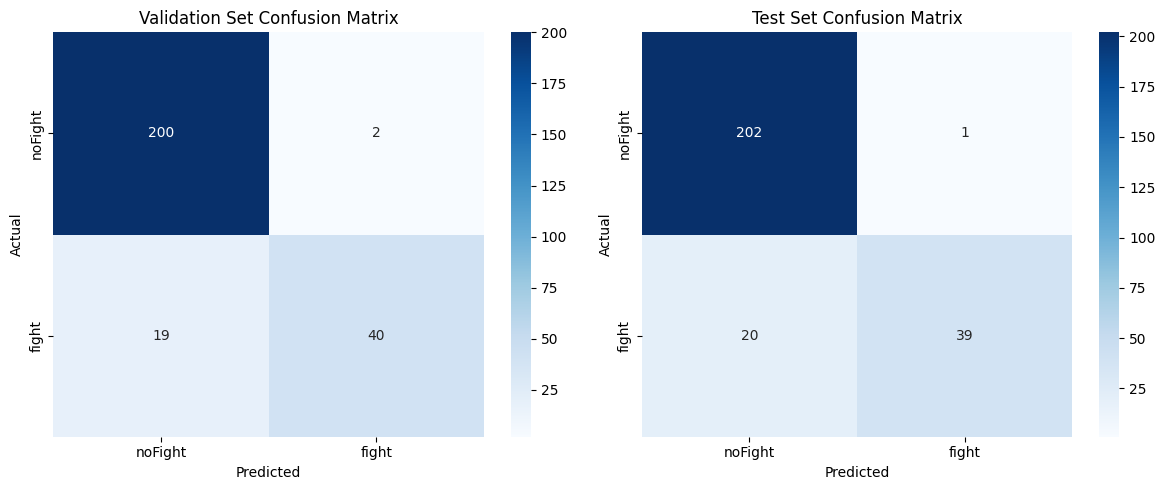

done with this


In [7]:
#  Model Evaluation (Kinda too much but meh)

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

y_val_pred_probs = best_model.predict(X_val)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

y_test_pred_probs = best_model.predict(X_test)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

def calculate_metrics(y_true, y_pred, y_pred_probs, set_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)

    print(f"{set_name} Metrics")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"AUC-ROC   : {auc:.4f}")

    return accuracy, precision, recall, f1, auc

val_metrics = calculate_metrics(y_val, y_val_pred, y_val_pred_probs.flatten(), "Validation")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_probs.flatten(), "Test")

print(f"Classification Report")
print("Validation Set:")
print(classification_report(y_val, y_val_pred, target_names=['noFight', 'fight']))
print("\nTest Set:")
print(classification_report(y_test, y_test_pred, target_names=['noFight', 'fight']))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', ax=axes[0],
            xticklabels=['noFight', 'fight'], # normal #fight = noFight , Fight
            yticklabels=['noFight', 'fight'], cmap='Blues')
axes[0].set_title('Validation Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1],
            xticklabels=['noFight', 'fight'],
            yticklabels=['noFight', 'fight'], cmap='Blues')
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print("done with this")

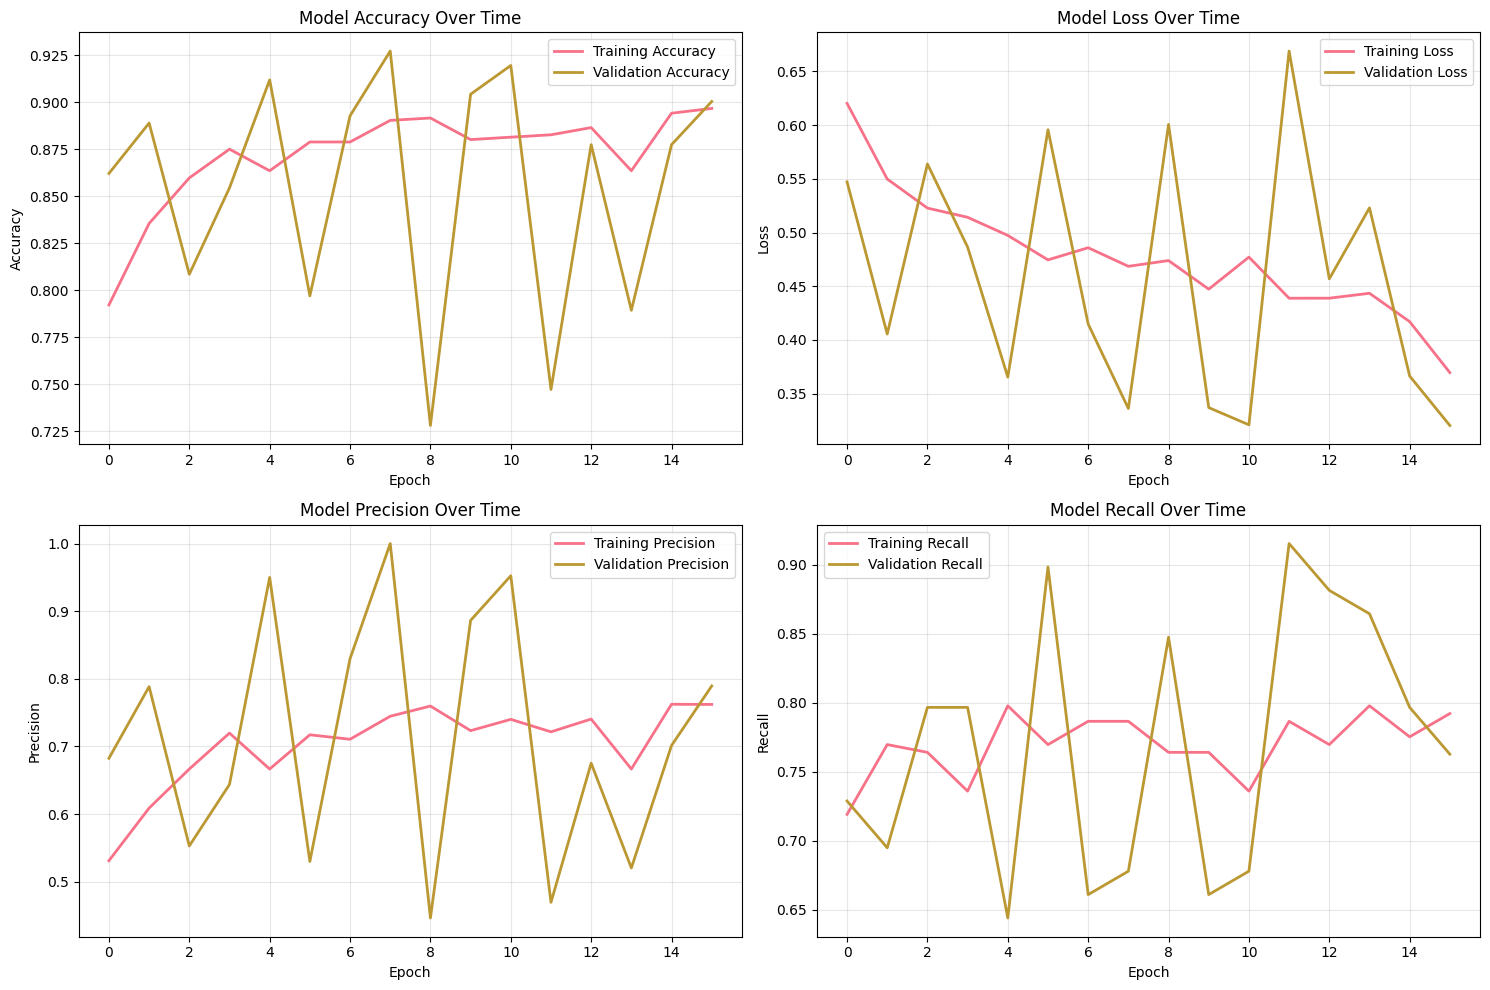

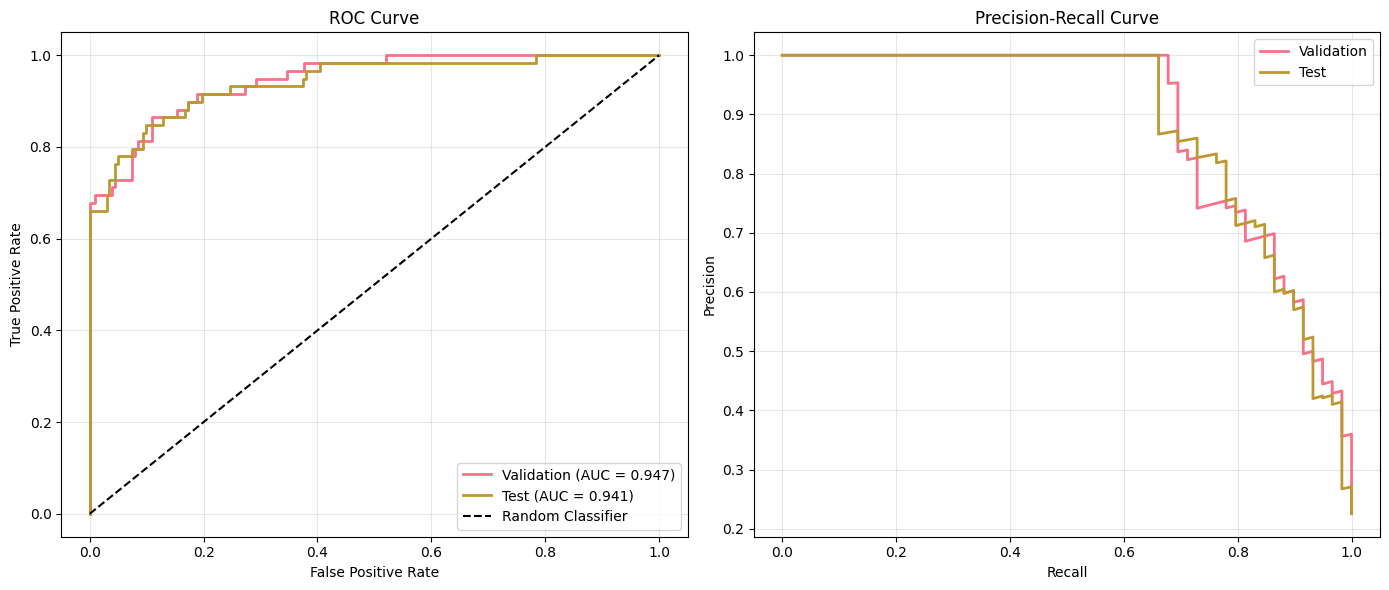

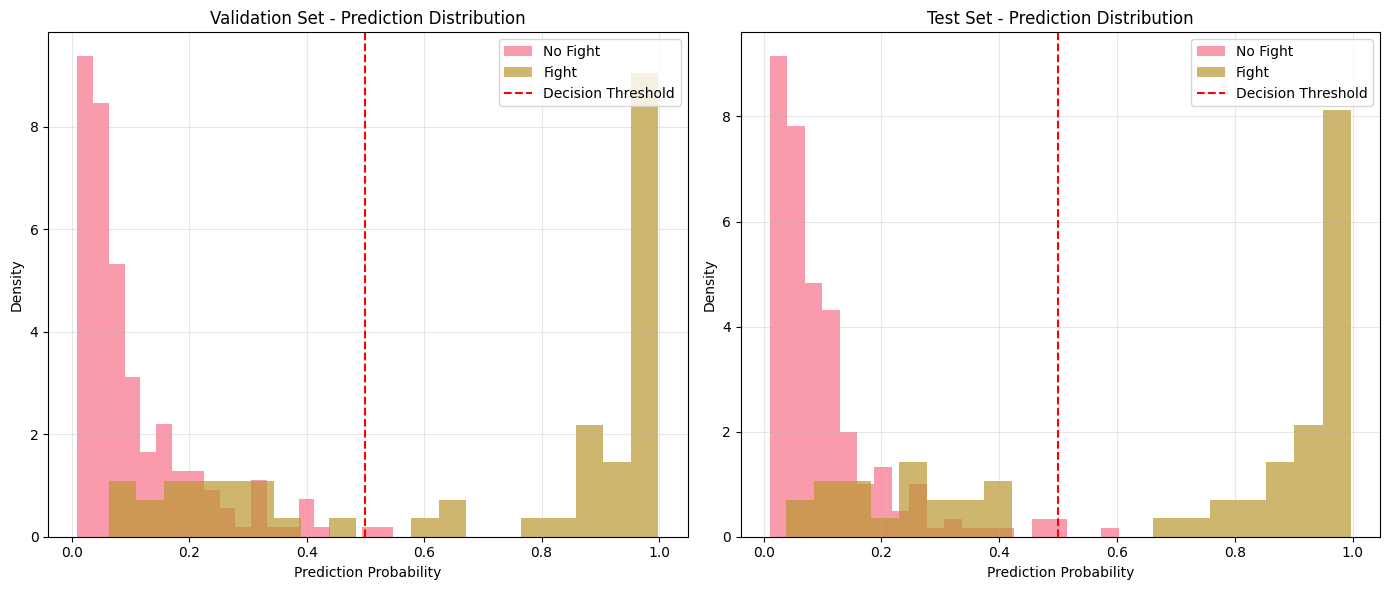

Done here


In [8]:
# Visualizations and analysis

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
import numpy as np

plt.style.use('default')
sns.set_palette("husl")

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy Over Time')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss Over Time')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
        axes[1, 0].set_title('Model Precision Over Time')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
        axes[1, 1].set_title('Model Recall Over Time')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_roc_and_pr_curves():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_probs)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_probs)

    axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {roc_auc_score(y_val, y_val_pred_probs):.3f})', linewidth=2)
    axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_score(y_test, y_test_pred_probs):.3f})', linewidth=2)
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_probs)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_probs)

    axes[1].plot(recall_val, precision_val, label='Validation', linewidth=2)
    axes[1].plot(recall_test, precision_test, label='Test', linewidth=2)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_prediction_distribution():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].hist(y_val_pred_probs[y_val == 0], bins=20, alpha=0.7, label='No Fight', density=True)
    axes[0].hist(y_val_pred_probs[y_val == 1], bins=20, alpha=0.7, label='Fight', density=True)
    axes[0].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
    axes[0].set_xlabel('Prediction Probability')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Validation Set - Prediction Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(y_test_pred_probs[y_test == 0], bins=20, alpha=0.7, label='No Fight', density=True)
    axes[1].hist(y_test_pred_probs[y_test == 1], bins=20, alpha=0.7, label='Fight', density=True)
    axes[1].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
    axes[1].set_xlabel('Prediction Probability')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Test Set - Prediction Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

plot_roc_and_pr_curves()

plot_prediction_distribution()

print("Done here")

In [9]:
# save best model and prediction function

import tensorflow as tf
import numpy as np
import cv2

MODEL_PATH = 'fight_detection_model_optimized.h5'
best_model.save(MODEL_PATH)
print(f"✅ Optimized model saved to {MODEL_PATH}")

def predict_video(video_path, model, threshold=0.5, verbose=True):

    try:
        frames = extract_frames(video_path, FRAMES_PER_VIDEO)

        if frames.shape[0] != FRAMES_PER_VIDEO:
            return {
                'error': f"Could not extract {FRAMES_PER_VIDEO} frames",
                'frames_extracted': frames.shape[0]
            }

        input_array = np.expand_dims(frames.astype(np.float32) / 255.0, axis=0)

        prediction_prob = model.predict(input_array, verbose=0)[0][0]
        prediction_label = "fight" if prediction_prob > threshold else "noFight"

        confidence_score = max(prediction_prob, 1 - prediction_prob)
        if confidence_score > 0.8:
            confidence_level = "High"
        elif confidence_score > 0.6:
            confidence_level = "Medium"
        else:
            confidence_level = "Low"

        result = {
            'prediction': prediction_label, # noFight Fight
            'probability': float(prediction_prob),
            'confidence_score': float(confidence_score),
            'confidence_level': confidence_level,  # High Low
            'threshold_used': threshold # 1, 0.5
        }

        if verbose:
            print(f"🎯 Prediction: {prediction_label}")
            print(f"📊 Probability: {prediction_prob:.4f}")
            print(f"🎚️ Confidence: {confidence_level} ({confidence_score:.4f})")

        return result

    except Exception as e:
        return {'error': f"Prediction failed: {str(e)}"}

def batch_predict_videos(video_paths, model, threshold=0.5):

# go through multiple videos at once

    results = []
    for i, video_path in enumerate(video_paths):
        print(f"\nProcessing video {i+1}/{len(video_paths)}: {video_path}")
        result = predict_video(video_path, model, threshold, verbose=True)
        results.append(result)
    return results

print("Done with this")

✅ Optimized model saved to fight_detection_model_optimized.h5
Done with this
